# Exercise 1: Introduction to pyiron

## Imports and and working with projects

In [127]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
%matplotlib inline

In [2]:
from pyiron import Project

In [6]:
pr = Project("demo")
# To delete all jobs and start from scratch, uncomment the next line
#pr.remove_jobs(recursive=True)


## Creating and manipulating structures

In [21]:
Al_struct = pr.create_ase_bulk("Al", cubic=True).repeat([2, 2, 4])
Al_struct.plot3d()

NGLWidget()

In [22]:
Al_struct.get_spacegroup()

{'InternationalTableSymbol': 'Fm-3m', 'Number': 225}

In [24]:
Al_struct[36] = "Cu"
Al_struct.plot3d(particle_size=3)

NGLWidget()

In [25]:
del Al_struct[17]
Al_struct.plot3d(particle_size=3)

NGLWidget()

## Perform a MD simulation of the AlH supercell using LAMMPS

In [30]:
Al_struct = pr.create_ase_bulk("Al", cubic=True)
H_struct = Al_struct.copy()
H_struct[:] = "H"
H_struct.scaled_positions += 0.5

In [31]:
Al_struct.set_repeat([2, 2, 4])
H_struct.set_repeat([2, 2, 4])

In [39]:
rand_int = np.arange(len(H_struct))
np.random.shuffle(rand_int)
H_int = H_struct[rand_int[:10]]

In [44]:
AlH_struct = Al_struct + H_int
AlH_struct.plot3d(particle_size=3)

NGLWidget()

In [55]:
job_lammps = pr.create_job(job_type=pr.job_type.Lammps, job_name="AlH_lammps")
job_lammps.structure = AlH_struct
print(job_lammps.list_potentials())
job_lammps.potential = 'Al_H_Ni_Angelo_eam'


['Al_H_Ni_Angelo_eam', '1995--Angelo-J-E--Ni-Al-H--LAMMPS--ipr1', '2018--Zhou-X-W--Al-Cu-H--LAMMPS--ipr1', 'EAM_Dynamo_AngeloMoodyBaskes_1995_NiAlH__MO_418978237058_005']


In [59]:
job_lammps.calc_md(temperature=600, n_ionic_steps=10000)
job_lammps.run()

The job AlH_lammps was saved and received the ID: 840


In [63]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,840,finished,Al64H10,AlH_lammps,/AlH_lammps,/home/surendralal/,pyiron_workshop_2020/demo/,2020-04-15 14:52:12.423406,2020-04-15 14:52:16.020394,3.0,pyiron@cmdell17#1,Lammps,0.1,None,None


In [64]:
job_lammps.animate_structure()

NGLWidget(max_frame=100)

## Analysis

In [73]:
Al_indices = AlH_struct.select_index("Al")
H_indices = AlH_struct.select_index("H")

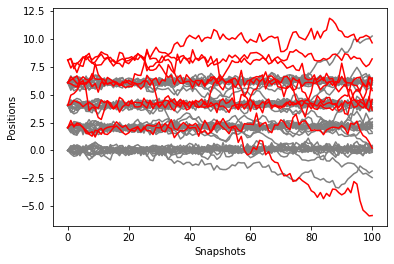

In [79]:
plt.plot(job_lammps.output.unwrapped_positions[:, Al_indices, 0], color="grey")
plt.plot(job_lammps.output.unwrapped_positions[:, H_indices, 0], color="red")
plt.xlabel("Snapshots")
plt.ylabel("Positions");

In [83]:
md_struct = job_lammps.get_structure(-1)
md_struct.plot3d()

NGLWidget()

In [84]:
job_lammps_minimize = pr.create_job(pr.job_type.Lammps, "AlH_minimize")
job_lammps_minimize.structure = md_struct
job_lammps_minimize.potential = job_lammps.potential.copy()

In [89]:
job_lammps_minimize.calc_minimize(pressure=0)
job_lammps_minimize.run()

The job AlH_minimize was saved and received the ID: 841


In [100]:
# Alternate way
job_continue = job_lammps.continue_with_final_structure(job_name="AlH_continue")
job_continue.potential = job_lammps.potential.copy()
job_continue.calc_minimize(pressure=0)
job_continue.run()

2020-04-15 15:13:39,598 - pyiron_log - WARNING - The job AlH_continue is being loaded instead of running. To re-run use the argument 'run_again=True'


In [99]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,840,finished,Al64H10,AlH_lammps,/AlH_lammps,/home/surendralal/,pyiron_workshop_2020/demo/,2020-04-15 14:52:12.423406,2020-04-15 14:52:16.020394,3.0,pyiron@cmdell17#1,Lammps,0.1,NaN,None
1,841,finished,Al64H10,AlH_minimize,/AlH_minimize,/home/surendralal/,pyiron_workshop_2020/demo/,2020-04-15 15:08:38.472691,2020-04-15 15:08:45.703586,7.0,pyiron@cmdell17#1,Lammps,0.1,NaN,None
2,842,finished,Al64H10,AlH_continue,/AlH_continue,/home/surendralal/,pyiron_workshop_2020/demo/,2020-04-15 15:12:21.599244,2020-04-15 15:12:41.879461,20.0,pyiron@cmdell17#1,Lammps,0.1,840.0,None


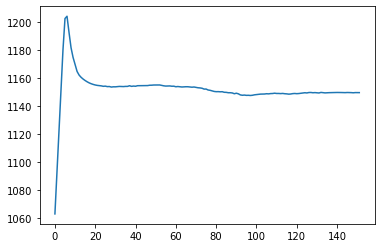

In [103]:
plt.plot(job_lammps_minimize.output.volume);

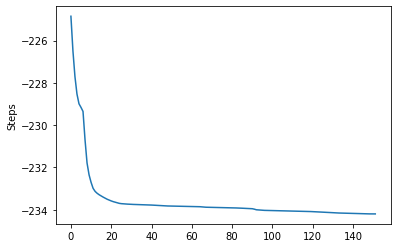

In [114]:
plt.plot(job_lammps_minimize["output/generic/energy_tot"])
plt.ylabel("Energy [eV]")
plt.ylabel("Steps");

In [107]:
minimize_struct = job_lammps_minimize.get_structure(-1)
minimize_struct.plot3d(particle_size=3)

NGLWidget()

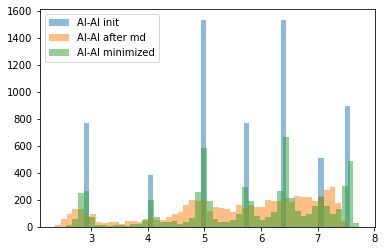

In [138]:
Al_only = AlH_struct[Al_indices]
neighbors = Al_only.get_neighbors(num_neighbors=100)
distances_Al = neighbors.distances.flatten()
plt.hist(distances_Al, bins=50, alpha=0.5, label="Al-Al init");
#H-H rdf
Al_only = md_struct[Al_indices]
neighbors = Al_only.get_neighbors(num_neighbors=100)
distances_Al = neighbors.distances.flatten()
plt.hist(distances_Al, bins=50, alpha=0.5, label="Al-Al after md");
#Al-Al rdf
Al_only = minimize_struct[Al_indices]
neighbors = Al_only.get_neighbors(num_neighbors=100)
distances_Al = neighbors.distances.flatten()
plt.hist(distances_Al, bins=50, alpha=0.5, label="Al-Al minimized")
plt.legend();

In [139]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,840,finished,Al64H10,AlH_lammps,/AlH_lammps,/home/surendralal/,pyiron_workshop_2020/demo/,2020-04-15 14:52:12.423406,2020-04-15 14:52:16.020394,3.0,pyiron@cmdell17#1,Lammps,0.1,NaN,None
1,841,finished,Al64H10,AlH_minimize,/AlH_minimize,/home/surendralal/,pyiron_workshop_2020/demo/,2020-04-15 15:08:38.472691,2020-04-15 15:08:45.703586,7.0,pyiron@cmdell17#1,Lammps,0.1,NaN,None
2,842,finished,Al64H10,AlH_continue,/AlH_continue,/home/surendralal/,pyiron_workshop_2020/demo/,2020-04-15 15:12:21.599244,2020-04-15 15:12:41.879461,20.0,pyiron@cmdell17#1,Lammps,0.1,840.0,None


## Energy-Volume curves using predefined modules



## Energy-volume curves for a variety of Al potentials
